## Introduction to Modeling with Python

Now that we have seen some examples of modeling and using Python for modeling, we wanted to give you a chance to try your hand!

To that goal, we choose a well structured problem with plenty of resources online to help you along the way. That problem is predicting housing prices and is hosted on Kaggle:

https://www.kaggle.com/c/house-prices-advanced-regression-techniques

First, make sure you are signed up on Kaggle and then download the data:

https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

The data includes both testing and training sets as well as a sample submission file. 

Your goal is the predict the sales price for each house where root mean squared error is the evaluation metric. To get some ideas on where to start, feel free to check out Kaggle Kernels:

https://www.kaggle.com/c/house-prices-advanced-regression-techniques/kernels

And the discussion board:

https://www.kaggle.com/c/house-prices-advanced-regression-techniques/discussion

Again - the goal of this homework is to get you exposed to modeling with Python. Feel free to use online resources to help guide you, but we expect original thought as well. Our hope is by the end of this homework you will feel comfortable exploring data in Python and building models to make predictions. Also please submit your test results to Kaggle and let us know your ranking and score!


### Grading

This homework is due **Feb. 20, 2018 by 3:00pm Utah time.** By that time, you need to have committed all your code to your github and submitted a link to your work to the TA. We can see on your Github account when you last committed code. :)

Rubric:

* Code Quality - 10%
* Storytelling - 10%
* Result on Kaggle - 5%
* Describing, Cleaning, and Visualizing data - 25%
* Modeling - 50%

More specifically, for modeling we will look for: 

* Model Selection: Did you try multiple models? Why did you choose these models? How do they work? What are they assumptions? And how did you test/account for them? How did you select hyper-parameters?
* Model interpretation: What do the model results tell you? Which variables are important? High bias or variance and how did you / could you fix this? How confident are you in your results? 
* Model usefulness: Do you think your final model was useful? If so, how would you recommend using it? Convince us, that if we were a company, we would feel comfortable using your model with our users. Think about edge cases as well - are there certain areas that the model performs poorly on? Best on? How would you handle these cases, if say Zillow wanted to leverage your model realizing that bad recommendations on sale prices would hurt customer trust and your brand. This section also falls into the storytelling aspect of the grading.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns #plt.style.use("seaborn")
%matplotlib inline

### Data Cleaning

In [73]:
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")
all_data = pd.concat((test, train), ignore_index=True)

In [3]:
all_data.shape

(2919, 81)

In [4]:
train.shape

(1460, 81)

In [5]:
all_data.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,896,0,0,NaN,2,1Fam,TA,No,468.0,144.0,...,WD,120,Pave,5,882.0,AllPub,140,1961,1961,2010
1,1329,0,0,NaN,3,1Fam,TA,No,923.0,0.0,...,WD,0,Pave,6,1329.0,AllPub,393,1958,1958,2010
2,928,701,0,NaN,3,1Fam,TA,No,791.0,0.0,...,WD,0,Pave,6,928.0,AllPub,212,1997,1998,2010
3,926,678,0,NaN,3,1Fam,TA,No,602.0,0.0,...,WD,0,Pave,7,926.0,AllPub,360,1998,1998,2010
4,1280,0,0,NaN,2,TwnhsE,TA,No,263.0,0.0,...,WD,144,Pave,5,1280.0,AllPub,0,1992,1992,2010


In [70]:
train.dropna(thresh=int(len(train)*.5), axis=1, inplace=True) #drops columns with more than 50% NANs

**Drop Variables**

After looping through the dataframe and printing out the normalized value counts of the object columns, I was able to identify which columns were worth keeping based on categorical distribution skewness. The columns with a category containing more than 60% of the data are will be dropped.

In [52]:
# dropped array stores skewed categorical columns to be dropped
dropped = []
keep = []
for i in train:
    if train[i].dtype == 'object':
        if train[i].value_counts(normalize=True, dropna=False).iloc[0] > .6:
            print(train[i].value_counts(normalize=True, dropna=False))
            dropped.append(i)
        else:
            keep.append(i)

RL         0.788356
RM         0.149315
FV         0.044521
RH         0.010959
C (all)    0.006849
Name: MSZoning, dtype: float64
Pave    0.99589
Grvl    0.00411
Name: Street, dtype: float64
NaN     0.937671
Grvl    0.034247
Pave    0.028082
Name: Alley, dtype: float64
Reg    0.633562
IR1    0.331507
IR2    0.028082
IR3    0.006849
Name: LotShape, dtype: float64
Lvl    0.897945
Bnk    0.043151
HLS    0.034247
Low    0.024658
Name: LandContour, dtype: float64
AllPub    0.999315
NoSeWa    0.000685
Name: Utilities, dtype: float64
Inside     0.720548
Corner     0.180137
CulDSac    0.064384
FR2        0.032192
FR3        0.002740
Name: LotConfig, dtype: float64
Gtl    0.946575
Mod    0.044521
Sev    0.008904
Name: LandSlope, dtype: float64
Norm      0.863014
Feedr     0.055479
Artery    0.032877
RRAn      0.017808
PosN      0.013014
RRAe      0.007534
PosA      0.005479
RRNn      0.003425
RRNe      0.001370
Name: Condition1, dtype: float64
Norm      0.989726
Feedr     0.004110
RRNn      0.

In [21]:
print("Columns to drop: ")
for i in dropped:
    print(i, sep='', end=', ', flush=True)

Columns to drop: 
MSZoning, Street, Alley, LotShape, LandContour, Utilities, LotConfig, LandSlope, Condition1, Condition2, BldgType, RoofStyle, RoofMatl, ExterQual, ExterCond, BsmtCond, BsmtExposure, BsmtFinType2, Heating, CentralAir, Electrical, Functional, GarageQual, GarageCond, PavedDrive, PoolQC, Fence, MiscFeature, SaleType, SaleCondition, 

In [53]:
# drops variables that do not meet the 60% threshhold
train.drop(dropped, axis=1, inplace=True)

**Additional Columns to Drop**

The following columns were dropped for reasons other than not meeting the categorical skewness threshold:
- 'Exterior2nd': The variable Exterior1st provides a sufficient metric for type of home exterior material
- 'GarageType': Since this variable has a lot of categories and there are many other descriptive "garage" variables, it does not make sense to keep 

In [54]:
# Drops other variables that do not add predictive power
train.drop(["Exterior2nd", "GarageType"], axis=1, inplace=True)

**Columns to transform:**
- 'Neighborhood' get dummies
- 'Exterior1st' get dummies for top 4 categories since they make up over 80% of the data
- 'HouseStyle' get dummies for 1 story and 2 story houses
- 'GarageFinish' encode as 1 for finished and 0 for unfinished
- 'Foundation' get dummies for 'PConc' and 'CBlock' and consolidate the other variables to 'other' category since they make up +87% of the data.
- 'MasVnrType' get dummies after consolidating 'brick' categories
- 'BsmtQual', 'HeatingQC', 'KitchenQual', and 'Fireplace' change to numeric scale
- 'BsmtFinType1' encode as a numeric quality scale

In [55]:
print("Columns to keep: ")
for i in keep:
    print(i, sep='', end=', ', flush=True)

Columns to keep: 
Neighborhood, HouseStyle, Exterior1st, Exterior2nd, MasVnrType, Foundation, BsmtQual, BsmtFinType1, HeatingQC, KitchenQual, FireplaceQu, GarageType, GarageFinish, 

In [70]:
train.FireplaceQu.value_counts(normalize=True, dropna=False)

0    0.472603
4    0.260274
3    0.214384
2    0.022603
5    0.016438
1    0.013699
Name: FireplaceQu, dtype: float64

In [57]:
# Reduces 'Exterior1st' column to just have 5 categories: 'VinylSd', 'HdBoard', 'MetalSd', 'Wd Sdng', and 'Other'
train.Exterior1st = train.Exterior1st.apply(lambda x: x if str(x)[0]=="V" or str(x)[0]=="H" or str(x)[0]=="M" 
                                           or str(x)[0:5]=="Wd Sd" else "Other")
# Creates dummies for new Exterior1st column
train = pd.get_dummies(train, columns=["Exterior1st"])

In [58]:
# Creates dummy variables for each Neighborhood
train = pd.get_dummies(train, columns=["Neighborhood"])

In [67]:
# Since 80% of the values are either 1 or 2 story houses, the other values are extraneous and uninformative
train["HouseStyle_1"] = np.where(train.HouseStyle.str.contains("1Story"), 1, 0)
train["HouseStyle_2"] = np.where(train.HouseStyle.str.contains("2Story"), 1, 0)
train.drop("HouseStyle", axis=1, inplace=True)

In [60]:
# Encodes 'GarageFinish' column to an indicator for houses with finished garages instead of categories
train.GarageFinish = train.GarageFinish.apply(lambda x: 1 if str(x)[0:3] == "Fin" else 0)

In [61]:
# Consolidates 'BrkFace' and 'BrkCmn' into one 'Brick' category
train.MasVnrType = train.MasVnrType.apply(lambda x: x if str(x)[0:3] != "Brk" else "Brick")

# Creates dummy variables for 'MasVnrType'
train = pd.get_dummies(train, columns=["MasVnrType"])

In [62]:
# Reduces 'Foundation' column to just have 3 categories: 'PConc', 'CBrick', and 'Other'
train.Foundation = train.Foundation.apply(lambda x: x if str(x)[0] == "P" or str(x)[0] == "C" else "Other")

# Creates dummy variables for each Neighborhood
train = pd.get_dummies(train, columns=["Foundation"])

In [74]:
# Dictionary assigning numeric values to categorical columns with a "poor" to "excellent"
num_assignments = {"BsmtQual": {"Ex":4, "Gd":3, "TA":2, "Fa":1, "Po":0},
                  "HeatingQC": {"Ex":4, "Gd":3, "TA":2, "Fa":1, "Po":0},
                  "KitchenQual": {"Ex":4, "Gd":3, "TA":2, "Fa":1, "Po":0},
                  "FireplaceQu": {"Ex":5, "Gd":4, "TA":3, "Fa":2, "Po":1, np.nan:0},
                  "BsmtFinType1": {"GLQ":6, "ALQ":5, "BLQ":4, "Rec":3, "LwQ":2, "Unf":1, np.nan:0}}
# Note: For 'FireplaceQu' and 'BsmtFinType1' the null values are set to zero as their own category. This makes sense
        # in context because the categories are measuring feature quality; Hence, if a feature is not reported it
        # cannot be characterized.
# Uses the 'num_assignments' dictionary to assign numeric values to the specified columns
train.replace(num_assignments, inplace=True)

In [64]:
for i in train:
    if train[i].dtype == 'object':
        if train[i].value_counts(normalize=True).iloc[0] < .6:
            print(train[i].value_counts(normalize=True))

1Story    0.497260
2Story    0.304795
1.5Fin    0.105479
SLvl      0.044521
SFoyer    0.025342
1.5Unf    0.009589
2.5Unf    0.007534
2.5Fin    0.005479
Name: HouseStyle, dtype: float64
Unf    0.302178
GLQ    0.293746
ALQ    0.154603
BLQ    0.104006
Rec    0.093465
LwQ    0.052003
Name: BsmtFinType1, dtype: float64


In [65]:
# creates variable measuring total square feet of the house
train["TotalSqFt"] = train.TotalBsmtSF + train.GrLivArea
# TotalBsmtSF = Total square feet of basement area
# GrLivArea = Total above grade (ground) living area square feet

train.drop(["TotalBsmtSF", "GrLivArea"], axis=1, inplace=True)

In [68]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id                      1460 non-null int64
MSSubClass              1460 non-null int64
LotFrontage             1201 non-null float64
LotArea                 1460 non-null int64
OverallQual             1460 non-null int64
OverallCond             1460 non-null int64
YearBuilt               1460 non-null int64
YearRemodAdd            1460 non-null int64
MasVnrArea              1452 non-null float64
BsmtQual                1423 non-null float64
BsmtFinType1            1423 non-null object
BsmtFinSF1              1460 non-null int64
BsmtFinSF2              1460 non-null int64
BsmtUnfSF               1460 non-null int64
HeatingQC               1460 non-null int64
1stFlrSF                1460 non-null int64
2ndFlrSF                1460 non-null int64
LowQualFinSF            1460 non-null int64
BsmtFullBath            1460 non-null int64
BsmtHalfBath            1460 non-null int64
FullBa

(array([    0.,   200.,   400.,   600.,   800.,  1000.]),
 <a list of 6 Text yticklabel objects>)

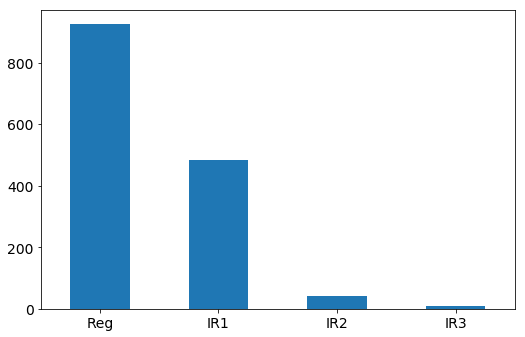

In [8]:
train.LotShape.value_counts().plot(kind='bar',rot=0, figsize=(8.5,5.5))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

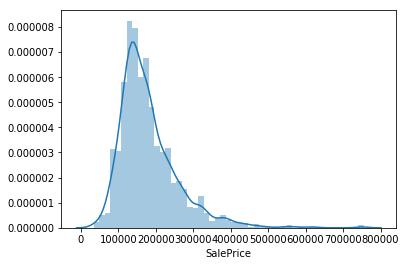

In [9]:
sns.distplot(train.SalePrice) #regularize

TotalBsmtSF: Total square feet of basement area
1stFlrSF: First Floor square feet
2ndFlrSF: Second floor square feet

-create dummies for MSZoning (6 zones), Street (gravel or paved)


In [41]:
numeric_feats = [all_data.dtypes[all_data.dtypes != "object"]]
#similar to: numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
numeric_feats[:]

[1stFlrSF           int64
 2ndFlrSF           int64
 3SsnPorch          int64
 BedroomAbvGr       int64
 BsmtFinSF1       float64
 BsmtFinSF2       float64
 BsmtFullBath     float64
 BsmtHalfBath     float64
 BsmtUnfSF        float64
 EnclosedPorch      int64
 Fireplaces         int64
 FullBath           int64
 GarageArea       float64
 GarageCars       float64
 GarageYrBlt      float64
 GrLivArea          int64
 HalfBath           int64
 Id                 int64
 KitchenAbvGr       int64
 LotArea            int64
 LotFrontage      float64
 LowQualFinSF       int64
 MSSubClass         int64
 MasVnrArea       float64
 MiscVal            int64
 MoSold             int64
 OpenPorchSF        int64
 OverallCond        int64
 OverallQual        int64
 PoolArea           int64
 SalePrice        float64
 ScreenPorch        int64
 TotRmsAbvGrd       int64
 TotalBsmtSF      float64
 WoodDeckSF         int64
 YearBuilt          int64
 YearRemodAdd       int64
 YrSold             int64
 dtype: obje

### Linear Regression

In [33]:
X_train, X_test, y_train, y_test = train_test_split(train, train.SalePrice, test_size=0.33, random_state=42)

In [38]:
regr = linear_model.LinearRegression()
regr.fit(X_train,y_train)
price_predict = regr.predict(X_test)

ValueError: could not convert string to float: 'Normal'

482